In [ ]:
# pip install -U scikit-learn scipy matplotlib
# !pip install seaborn
# !pip install statsmodels

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from math import *

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:
target_region = 'Emiliani2'
csv_with_aggreg = "./features_with_aggregations_" + target_region + ".csv"

# load csv with features
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [6]:
features_no_aggreg = all_features.iloc[:,:3]
features_no_aggreg

,date,cyclostationary_mean_Emiliani2_tg,cyclostationary_mean_Emiliani2_rr
0,2001-01-05,0.560024,2.593484
1,2001-01-13,3.357927,2.233199
2,2001-01-21,-0.945032,-0.273202
3,2001-01-29,2.552268,1.537071
4,2001-02-06,0.665864,0.256329
...,...,...,...
976,2022-05-23,4.624119,-2.301169
977,2022-05-31,2.601352,-0.050708
978,2022-06-08,3.769107,-2.618173
979,2022-06-16,2.993290,-0.669589


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e9ca58d00>,
      dtype=object)

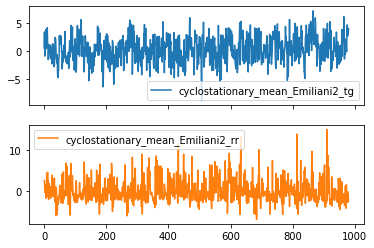

In [7]:
features_no_aggreg.plot(subplots=True)

### Regression with incremental index to study mean stationarity

In [8]:
# we already have cyclostationary means

tg = features_no_aggreg.iloc[:, 1:2].values
rr = features_no_aggreg.iloc[:, 2:].values
X = features_no_aggreg.index.values
X = X.reshape(X.shape[0], 1)

#create linear models
regression_temperature = LinearRegression()
regression_rain = LinearRegression()

#fit linear models
regression_temperature.fit(X, tg)
regression_rain.fit(X, rr)

print('Coefficients temperature: \n', '{:.20f}'.format(regression_temperature.coef_[0][0]), regression_temperature.intercept_[0])
print('Coefficients rain: \n', '{:.20f}'.format(regression_rain.coef_[0][0]), regression_rain.intercept_[0])

Coefficients temperature: 
 0.00118496237980993688 -0.2786735032102663
Coefficients rain: 
 -0.00003382488041177360 -0.0023435611270962928


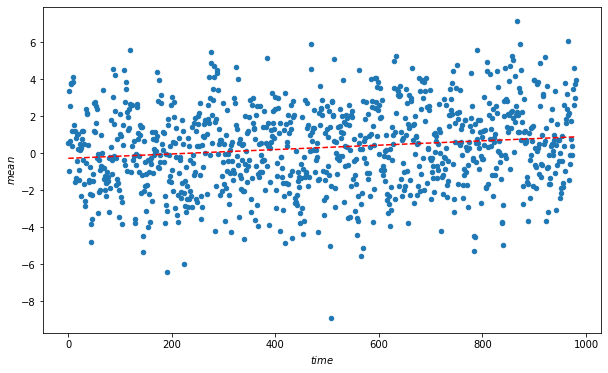

In [9]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

# Plot best-fit line
best_fit = regression_temperature.intercept_ + regression_temperature.coef_[0] * X

ax_scat.scatter(X, tg, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel(r'$time$')
ax_scat.set_ylabel(r'$mean$');

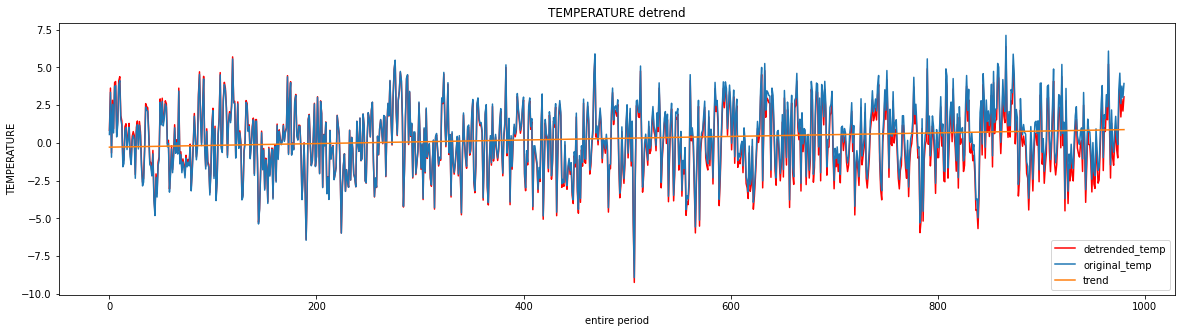

In [11]:
trend_temp = regression_temperature.predict(X) # values of the red dotted line (best fit line) above
detrended_temp = [tg[i]-trend_temp[i] for i in range(0, len(X))]

plt.plot(detrended_temp, color='red', label = "detrended_temp")
plt.plot(tg, label = "original_temp")
plt.plot(trend_temp, label ="trend")
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel("entire period")
plt.ylabel("TEMPERATURE")
plt.title("TEMPERATURE detrend")

plt.legend(loc="lower right")

plt.show()

In [12]:
trend_temp.max()

0.8825896290034718

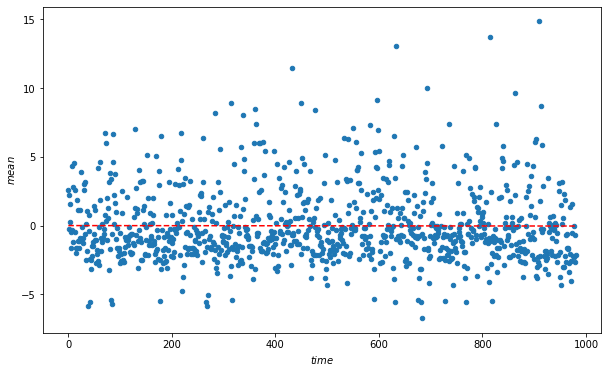

In [13]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

# Plot best-fit line
best_fit = regression_rain.intercept_ + regression_rain.coef_[0] * X

ax_scat.scatter(X, rr, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel(r'$time$')
ax_scat.set_ylabel(r'$mean$');

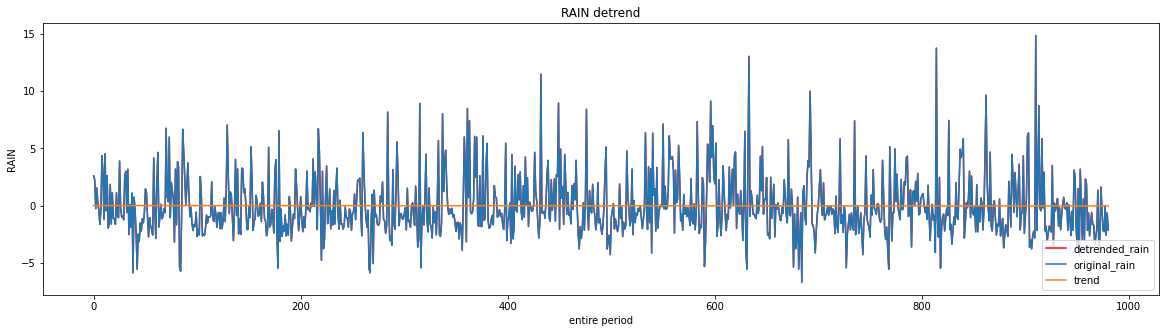

In [14]:
trend_rain = regression_rain.predict(X) # values of the red dotted line (best fit line) above
detrended_rain = [rr[i]-trend_rain[i] for i in range(0, len(X))]

plt.plot(detrended_rain, color='red', label = "detrended_rain")
plt.plot(rr, label = "original_rain")
plt.plot(trend_rain, label ="trend")
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel("entire period")
plt.ylabel("RAIN")
plt.title("RAIN detrend")

plt.legend(loc="lower right")

plt.show()

In [15]:
trend_rain.max()

-0.0023435611270962928

#### Augmented Dickey-Fuller test
for stationarity: p_value < 0.05 and test_stat < critical values

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    result = adfuller(timeseries, autolag="AIC")
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [17]:
# temperature
adf_test(features_no_aggreg.iloc[:, 1:2])

Results of Dickey-Fuller Test:
ADF Statistic: -6.921418
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [18]:
# rain
adf_test(features_no_aggreg.iloc[:, 2:])

Results of Dickey-Fuller Test:
ADF Statistic: -15.828980
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
for stationarity: p_value > 0.05 and test_stat < critical values

In [19]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = '{:.20f}'.format(value)
    print (kpss_output)

In [20]:
# temperature
kpss_test(features_no_aggreg.iloc[:, 1:2]) # FAILED

Results of KPSS Test:
Test Statistic                         0.905248
p-value                                    0.01
#Lags Used                                 12.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [21]:
# rain
kpss_test(features_no_aggreg.iloc[:, 2:])

Results of KPSS Test:
Test Statistic                         0.142608
p-value                                     0.1
#Lags Used                                  9.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
